### Dataset Loading and Libraries Import
In this section dataset is loaded from github repository. \
It consists of 2 folders (Training, Testing), which are divided into tumor categories in turn.

Install library for segmentation models

In [ ]:
!pip install -U segmentation-models-pytorch

Download classification dataset from Github

In [ ]:
!mkdir DataSet
!cd Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import imutils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, datasets, transforms

import segmentation_models_pytorch as smp

from tqdm import tqdm

import ipywidgets as widgets
import io
import os

In [269]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

### Data Visualization
In this section training images are loaded and visualized by category.

In [7]:
folder_train_path = 'DataSet/Brain-Tumor-Classification-DataSet/Training'
folder_test_path = 'DataSet/Brain-Tumor-Classification-DataSet/Testing'

Categories = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [281]:
def load_images(folder_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    images = []
    path = os.listdir(folder_path)
    path.sort()
    for filename in path:
        img = Image.open(os.path.join(folder_path, filename)).convert('RGB')
        image = transform(img)
        images.append(image)
    return images

def flatten(x):
  return [el for el_set in x for el in el_set]

In [282]:
train_set, test_set, train_label_set, test_label_set = [], [], [], []

for category in Categories:
    train_path = os.path.join(folder_train_path, category)
    test_path = os.path.join(folder_test_path, category)
    
    train_data = load_images(train_path)
    test_data = load_images(test_path)
    
    train_set.append(train_data)
    test_set.append(test_data)
    train_label_set.append(np.full(len(train_data), category))
    test_label_set.append(np.full(len(test_data), category))

In [283]:
train_data = flatten(train_set)
train_labels = np.array(flatten(train_label_set))
test_data = flatten(test_set)
test_labels = np.array(flatten(test_label_set))

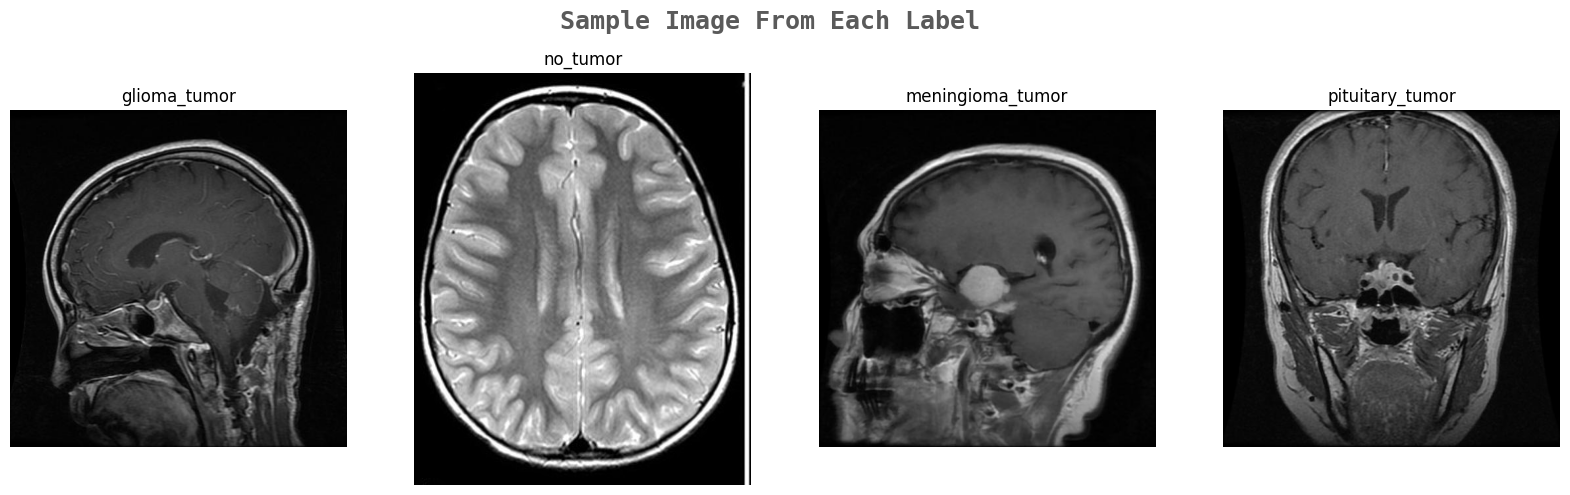

In [284]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for cat in Categories:
    j=9
    ind = np.random.choice(np.where(train_labels == cat)[0])
    img = train_data[ind]
    ax[k].imshow(img.permute(1,2,0))
    ax[k].set_title(cat)
    ax[k].axis('off')
    k+=1

### Setting Transformers
In this section we initialize train and test transformers for data augmentation.

In [285]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

### Data Preprocessing and Splitting
In this section the goal is to apply transformations for initial images to increase their quality in terms of training a deep learning algorithm. \
After that, train/test/validation dataloader is created.

In [286]:
train_data_path = 'DataSet/Brain-Tumor-Classification-DataSet/Training'
test_data_path = 'DataSet/Brain-Tumor-Classification-DataSet/Testing'

train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))  # 80% of data for training
val_size = len(train_dataset) - train_size  # 20% for validation
train, val = random_split(train_dataset, [train_size, val_size])

batch_size = 32 

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Setting a Device

In [224]:
device = "cuda"

### Creating Segmentation Mask
In this section pretrained segmentation model is used to create a mask on the current dataset.

Initialize and load segmentation model

In [13]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

In [14]:
model_name = 'DeepLabV3+'
model = smp.DeepLabV3Plus(**common_params)
weight_path = f'../Segmentation/{model_name}_best-3.pth'
model.load_state_dict(torch.load(weight_path, map_location=device), strict=False)
model = model.to(device)
model.eval()

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

Predict mask for initial images

In [225]:
def plot_pair(image,mask):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
    axes[0].imshow(image)
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].imshow(mask)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    fig.tight_layout()


def overlay_mask_on_image(image, mask, alpha=0.4):
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    final_img = cv2.addWeighted(mask_bgr, alpha, image, 1-alpha, 0)
    return final_img

In [226]:
def estimate_mask(input_image, device):
    input_image = input_image.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(input_image)
        if isinstance(output, tuple):
            output = output[0]
        prediction = torch.sigmoid(output)
        predicted_mask = (prediction > 0.55).float()
    return predicted_mask

In [227]:
X_train_mask, X_test_mask = [], []
for img in train_data:
    img = transforms.Resize(size=(512,512))(img)
    mask = estimate_mask(img, device)[0]
    mask_ = mask.cpu().permute(1,2,0).numpy()
    img_ = img.permute(1,2,0).numpy()
    
    new_img = overlay_mask_on_image(img_, mask_)
    X_train_mask.append(new_img)

for img in test_data:
    img = transforms.Resize(size=(512,512))(img)
    mask = estimate_mask(img, device)[0]
    mask_ = mask.cpu().permute(1,2,0).numpy()
    img_ = img.permute(1,2,0).numpy()
    
    new_img = overlay_mask_on_image(img_, mask_)
    X_test_mask.append(new_img)

Apply train/test transformations 

In [228]:
X_train_mask_transformed, X_test_mask_transformed = [], []
for img in X_train_mask:
    pil_img = transforms.ToPILImage()(img)
    X_train_mask_transformed.append(train_transforms(pil_img))

for img in X_test_mask:
    pil_img = transforms.ToPILImage()(img)
    X_test_mask_transformed.append(test_transforms(pil_img))

Visualize masks and images

meningioma_tumor


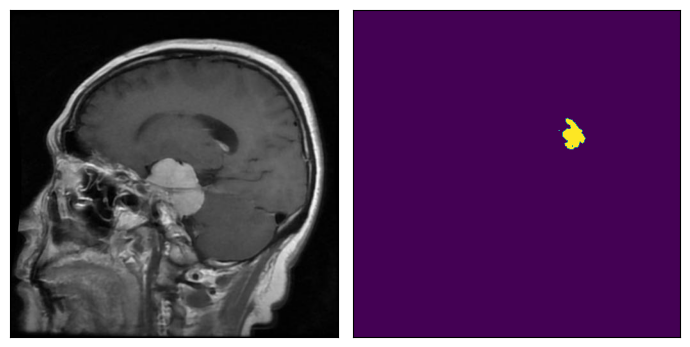

In [258]:
idx = 2004
print(train_labels[idx])
img = train_data[idx]
mask = estimate_mask(img, device)[0]
plot_pair(img.permute(1,2,0), mask.cpu().permute(1,2,0).numpy())

glioma_tumor


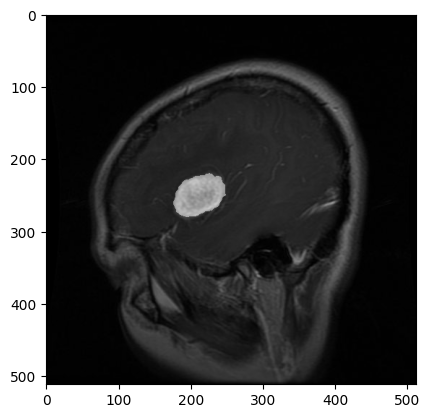

In [305]:
idx = 5
print(train_labels[idx])
plt.imshow(X_train_mask[idx]);

### Set numerical category to the tumor type

In [229]:
enc = LabelEncoder()
y = enc.fit_transform(Categories)
y_train = enc.transform(train_labels)
y_test = enc.transform(test_labels)

### Masked Data Preprocessing and Splitting
In this section the goal is to create a train/test dataset from transformed masked images and create train/test/validation dataloader.

In [230]:
class Dataset():
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32

train_dataset = Dataset(X_train_mask_transformed, y_train)
test_dataset = Dataset(X_test_mask_transformed, y_test)

train_size = int(0.8 * len(train_dataset))  # 80% of data for training
val_size = len(train_dataset) - train_size  # 20% for validation
train, val = random_split(train_dataset, [train_size, val_size])

masked_train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)
masked_val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0)
masked_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Training Deep Learning Models
In this section training and testing epochs are created with early stopping criteria. Computing metrics is provided. The best model is saved into "best_model.pth".

In [295]:
def calculate_metrics(output, target):
    with torch.no_grad():
        prediction = output.argmax(dim=-1, keepdim=True)
        correct = prediction.eq(target.view_as(prediction)).sum().item()
        precision = precision_score(target.cpu(), prediction.cpu(), average='macro', zero_division=0.0)
        recall = recall_score(target.cpu(), prediction.cpu(), average='macro', zero_division=0.0)
        f1 = f1_score(target.cpu(), prediction.cpu(), average='macro', zero_division=0.0)
    return correct, precision, recall, f1

In [298]:
def epoch_train(data_loader, clf, criterion, opt, device):
    train_acc, running_loss = 0, 0
    precision_list, recall_list, f1_list = [], [], []
    clf.train(True)
    for i, data in enumerate(data_loader, 1):
        model_input, target = data[0].to(device), data[1].to(device)
        opt.zero_grad()
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        metrics = calculate_metrics(model_output, target)
        train_acc += metrics[0]
        precision_list.append(metrics[1])
        recall_list.append(metrics[2])
        f1_list.append(metrics[3])
        
    avg_loss = running_loss / len(data_loader)
    avg_acc = train_acc / len(data_loader.dataset)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    
    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1

def epoch_test(data_loader, clf, criterion, device):
    test_acc, running_loss = 0, 0
    precision_list, recall_list, f1_list = [], [], []
    clf.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 1):
            model_input, target = data[0].to(device), data[1].to(device)
            model_output = clf(model_input)
            loss = criterion(model_output, target)

            running_loss += loss.item()
            metrics = calculate_metrics(model_output, target)
            test_acc += metrics[0]
            precision_list.append(metrics[1])
            recall_list.append(metrics[2])
            f1_list.append(metrics[3])
            
    avg_loss = running_loss / len(data_loader)
    avg_acc = test_acc / len(data_loader.dataset)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1

In [321]:
def train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=15):
    best_val_loss = float('inf')
    patience = 7  # Number of epochs to wait after last time validation loss improved.
    trigger_times = 0  # Count how many times the validation loss didn't improve.

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        
        train_loss, train_acc, train_precision, train_recall, train_f1 = epoch_train(train_loader, clf, criterion, opt, device)

        val_loss, val_acc, val_precision, val_recall, val_f1 = epoch_test(val_loader, clf, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        if val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving the model!")
            best_val_loss = val_loss
            trigger_times = 0
            # Save the model if validation loss decreases
            # torch.save(clf.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            print(f"Validation loss did not improve this epoch. ({trigger_times}/{patience})")

        if trigger_times >= patience:
            print("Early stopping!")
            break

        print(f'[Epoch {epoch + 1}/{n_epochs}] Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}, ' +
              f'Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}, ' +
              f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}, ' +
              f'Val Precision: {val_precision:.2f}, Val Recall: {val_recall:.2f}, Val F1: {val_f1:.2f}')

        scheduler.step(val_loss)

    # plot metrics
    epochs_range = range(1, epoch + 2)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, train_precisions, label='Train Precision')
    plt.plot(epochs_range, val_precisions, label='Val Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, train_recalls, label='Train Recall')
    plt.plot(epochs_range, val_recalls, label='Val Recall')
    plt.title('Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, train_f1s, label='Train F1 Score')
    plt.plot(epochs_range, val_f1s, label='Val F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

Initialize classification models

#### ResNet18

In [332]:
clf = models.resnet18(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### ResNet34

In [330]:
clf = models.resnet34(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.008, momentum=0.7, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### ResNet50

In [336]:
clf = models.resnet50(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.008, momentum=0.7, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### EfficientNet

In [324]:
clf = models.efficientnet_b0(weights=None)
clf = clf.cuda() if torch.cuda.is_available() else clf
opt = torch.optim.SGD(clf.parameters(), lr=0.005, momentum=0.7, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

#### Training Model on Original Data

efficientnet

Epoch 1/35
Validation loss decreased (inf --> 1.526645). Saving the model!
[Epoch 1/35] Train Loss: 2.523, Train Acc: 0.36, Train Precision: 0.34, Train Recall: 0.35, Train F1: 0.31, Val Loss: 1.527, Val Acc: 0.47, Val Precision: 0.49, Val Recall: 0.44, Val F1: 0.41
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.103, Train Acc: 0.53, Train Precision: 0.55, Train Recall: 0.53, Train F1: 0.51, Val Loss: 2.897, Val Acc: 0.45, Val Precision: 0.39, Val Recall: 0.40, Val F1: 0.36
Epoch 3/35
Validation loss decreased (1.526645 --> 1.160644). Saving the model!
[Epoch 3/35] Train Loss: 1.022, Train Acc: 0.57, Train Precision: 0.57, Train Recall: 0.57, Train F1: 0.54, Val Loss: 1.161, Val Acc: 0.61, Val Precision: 0.62, Val Recall: 0.61, Val F1: 0.59
Epoch 4/35
Validation loss did not improve this epoch. (1/7)
[Epoch 4/35] Train Loss: 0.929, Train Acc: 0.62, Train Precision: 0.62, Train Recall: 0.63, Train F1: 0.60, Val Loss: 1.306, Val Acc: 0.65, Val Pre

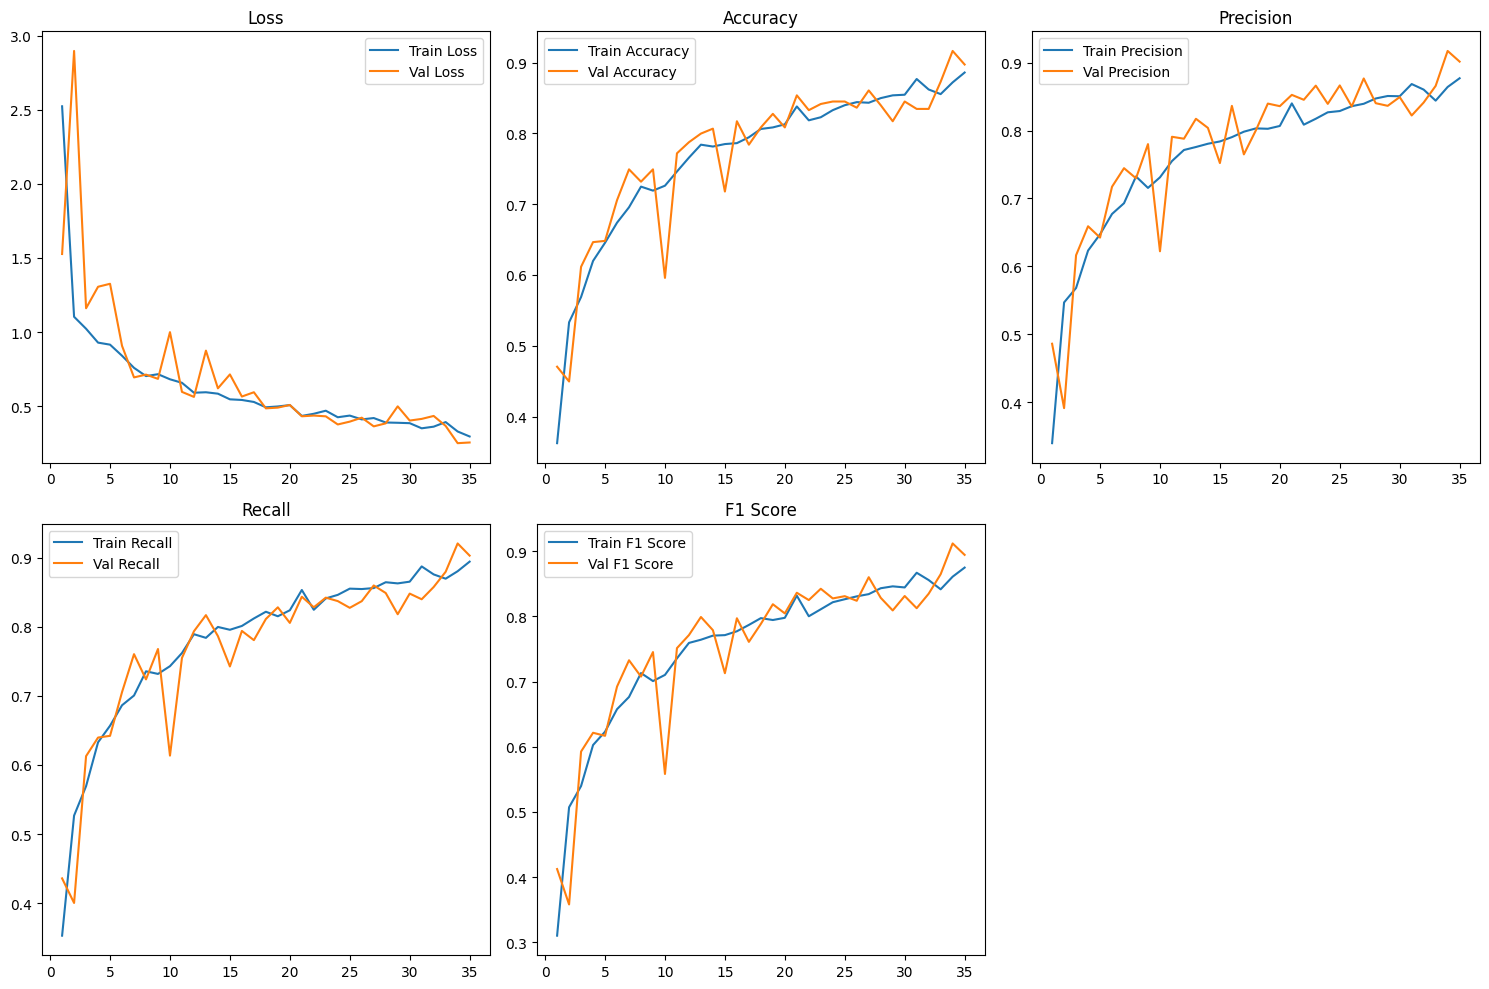

In [300]:
train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet34

Epoch 1/35
Validation loss decreased (inf --> 1.229896). Saving the model!
[Epoch 1/35] Train Loss: 1.475, Train Acc: 0.43, Train Precision: 0.39, Train Recall: 0.41, Train F1: 0.35, Val Loss: 1.230, Val Acc: 0.48, Val Precision: 0.60, Val Recall: 0.49, Val F1: 0.45
Epoch 2/35
Validation loss decreased (1.229896 --> 1.178935). Saving the model!
[Epoch 2/35] Train Loss: 1.154, Train Acc: 0.51, Train Precision: 0.52, Train Recall: 0.50, Train F1: 0.46, Val Loss: 1.179, Val Acc: 0.50, Val Precision: 0.49, Val Recall: 0.54, Val F1: 0.44
Epoch 3/35
Validation loss decreased (1.178935 --> 1.018023). Saving the model!
[Epoch 3/35] Train Loss: 1.004, Train Acc: 0.59, Train Precision: 0.57, Train Recall: 0.57, Train F1: 0.53, Val Loss: 1.018, Val Acc: 0.58, Val Precision: 0.59, Val Recall: 0.55, Val F1: 0.54
Epoch 4/35
Validation loss did not improve this epoch. (1/7)
[Epoch 4/35] Train Loss: 0.949, Train Acc: 0.60, Train Precision: 0.62, Train Recall: 0.60, Train F1: 0.57, Val Loss: 1.138, Val

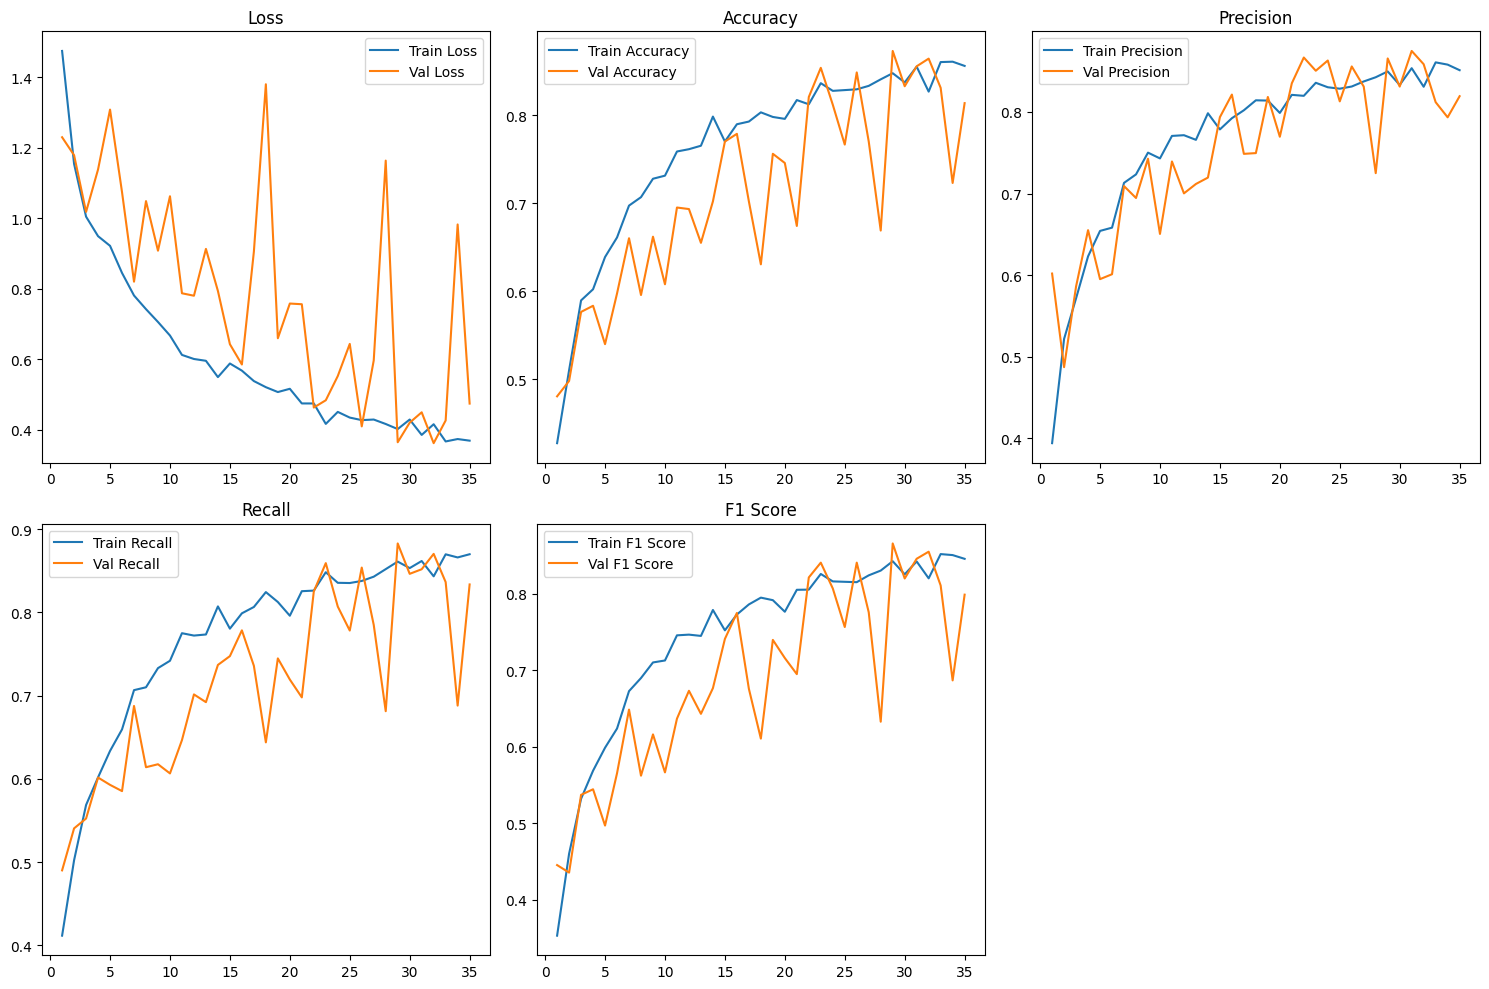

In [327]:
train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet18

Epoch 1/35
Validation loss decreased (inf --> 1.102992). Saving the model!
[Epoch 1/35] Train Loss: 1.671, Train Acc: 0.42, Train Precision: 0.40, Train Recall: 0.41, Train F1: 0.36, Val Loss: 1.103, Val Acc: 0.51, Val Precision: 0.54, Val Recall: 0.46, Val F1: 0.45
Epoch 2/35
Validation loss decreased (1.102992 --> 1.001974). Saving the model!
[Epoch 2/35] Train Loss: 1.056, Train Acc: 0.54, Train Precision: 0.55, Train Recall: 0.53, Train F1: 0.50, Val Loss: 1.002, Val Acc: 0.59, Val Precision: 0.62, Val Recall: 0.58, Val F1: 0.58
Epoch 3/35
Validation loss did not improve this epoch. (1/7)
[Epoch 3/35] Train Loss: 0.960, Train Acc: 0.59, Train Precision: 0.58, Train Recall: 0.58, Train F1: 0.54, Val Loss: 1.088, Val Acc: 0.56, Val Precision: 0.57, Val Recall: 0.60, Val F1: 0.56
Epoch 4/35
Validation loss did not improve this epoch. (2/7)
[Epoch 4/35] Train Loss: 0.905, Train Acc: 0.62, Train Precision: 0.65, Train Recall: 0.61, Train F1: 0.59, Val Loss: 1.217, Val Acc: 0.53, Val Pre

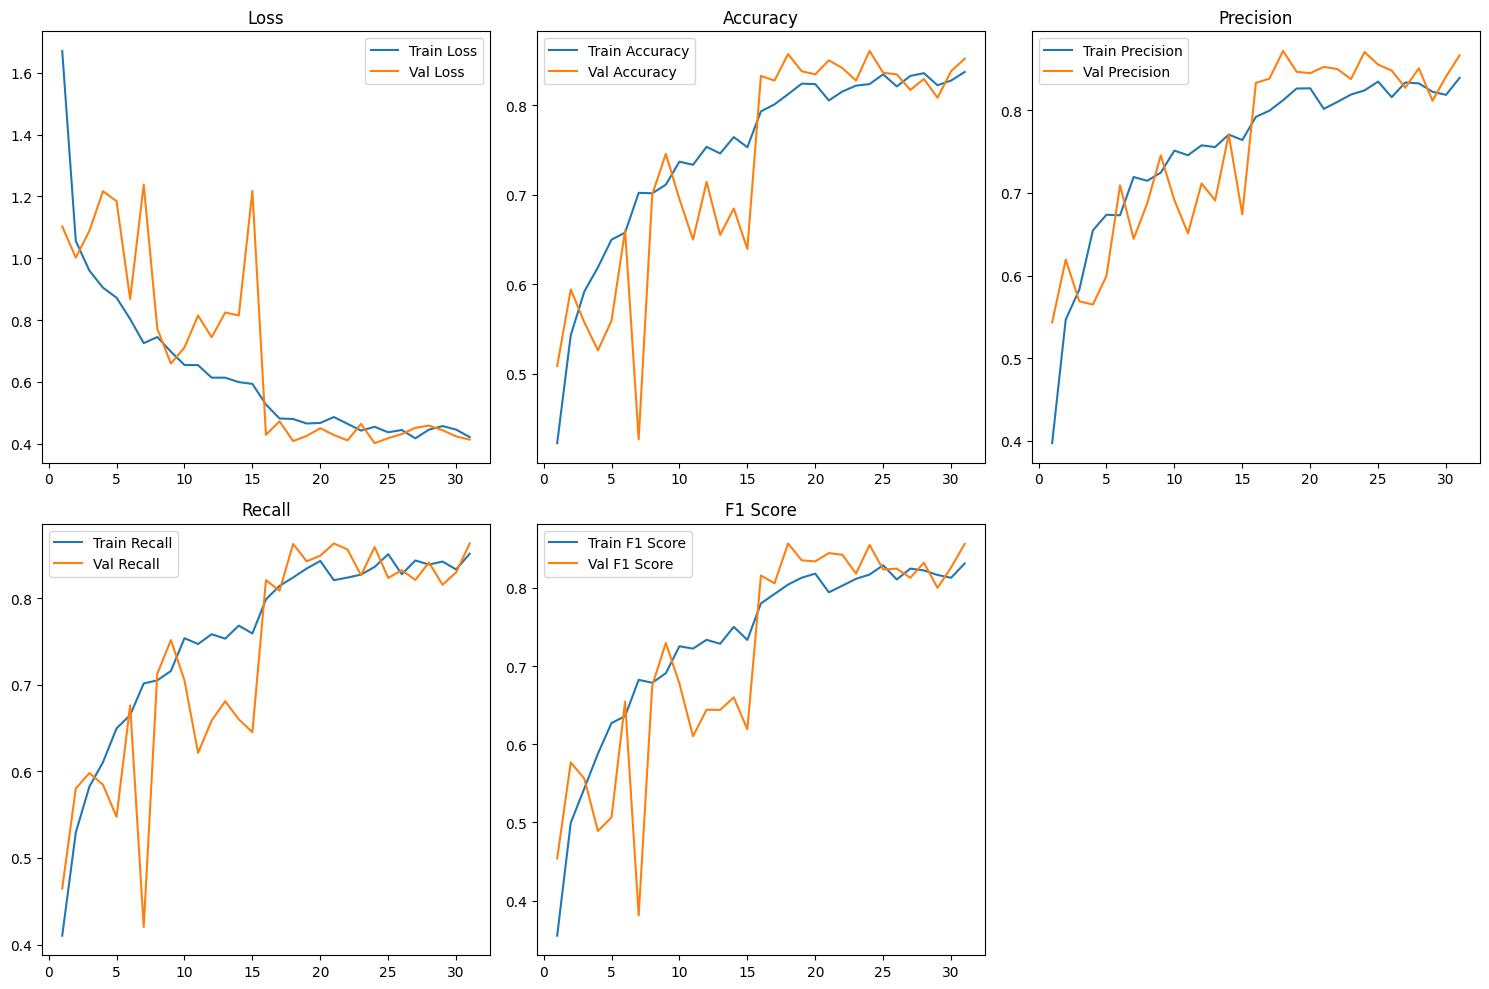

In [329]:
train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet50

Epoch 1/35
Validation loss decreased (inf --> 1.277786). Saving the model!
[Epoch 1/35] Train Loss: 2.181, Train Acc: 0.35, Train Precision: 0.23, Train Recall: 0.34, Train F1: 0.23, Val Loss: 1.278, Val Acc: 0.46, Val Precision: 0.47, Val Recall: 0.42, Val F1: 0.39
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.515, Train Acc: 0.42, Train Precision: 0.36, Train Recall: 0.40, Train F1: 0.33, Val Loss: 1.563, Val Acc: 0.51, Val Precision: 0.40, Val Recall: 0.44, Val F1: 0.39
Epoch 3/35
Validation loss did not improve this epoch. (2/7)
[Epoch 3/35] Train Loss: 1.271, Train Acc: 0.49, Train Precision: 0.46, Train Recall: 0.48, Train F1: 0.43, Val Loss: 1.397, Val Acc: 0.47, Val Precision: 0.52, Val Recall: 0.45, Val F1: 0.41
Epoch 4/35
Validation loss did not improve this epoch. (3/7)
[Epoch 4/35] Train Loss: 1.251, Train Acc: 0.51, Train Precision: 0.49, Train Recall: 0.51, Train F1: 0.46, Val Loss: 2.067, Val Acc: 0.46, Val Precision: 0.36, Val R

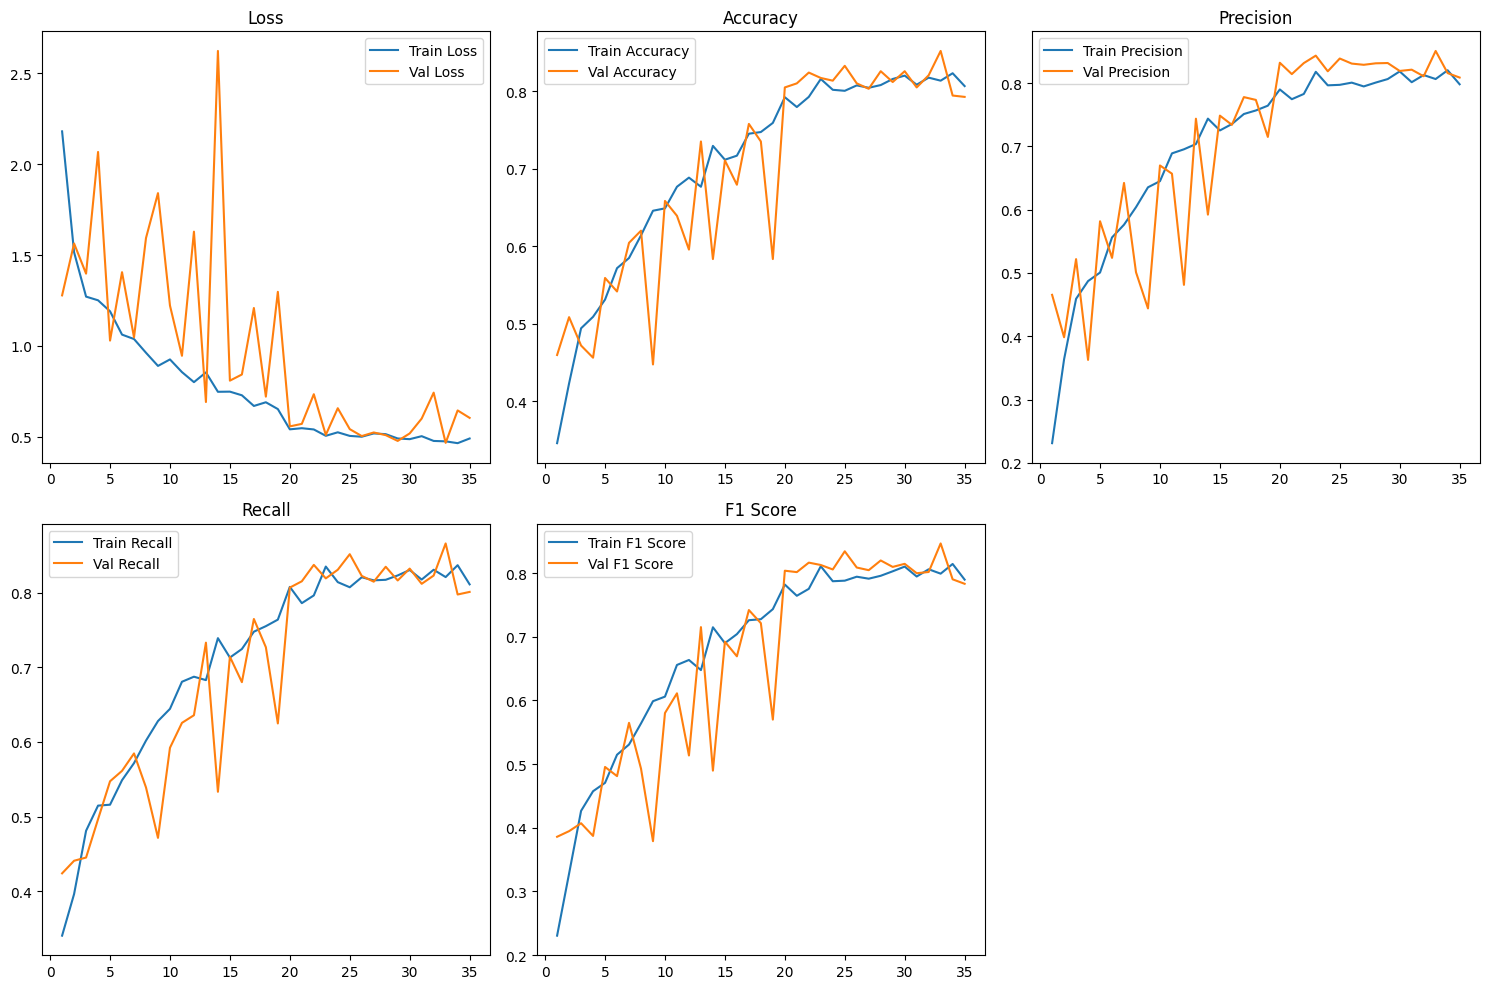

In [337]:
train_model(train_loader, val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

#### Training Model on Masked Data

efficientnet

Epoch 1/35
Validation loss decreased (inf --> 2.434348). Saving the model!
[Epoch 1/35] Train Loss: 3.203, Train Acc: 0.38, Train Precision: 0.33, Train Recall: 0.34, Train F1: 0.31, Val Loss: 2.434, Val Acc: 0.37, Val Precision: 0.20, Val Recall: 0.33, Val F1: 0.24
Epoch 2/35
Validation loss decreased (2.434348 --> 2.317828). Saving the model!
[Epoch 2/35] Train Loss: 1.198, Train Acc: 0.52, Train Precision: 0.53, Train Recall: 0.51, Train F1: 0.48, Val Loss: 2.318, Val Acc: 0.45, Val Precision: 0.43, Val Recall: 0.47, Val F1: 0.39
Epoch 3/35
Validation loss decreased (2.317828 --> 1.986457). Saving the model!
[Epoch 3/35] Train Loss: 1.065, Train Acc: 0.56, Train Precision: 0.57, Train Recall: 0.54, Train F1: 0.53, Val Loss: 1.986, Val Acc: 0.38, Val Precision: 0.32, Val Recall: 0.41, Val F1: 0.31
Epoch 4/35
Validation loss decreased (1.986457 --> 1.220786). Saving the model!
[Epoch 4/35] Train Loss: 0.960, Train Acc: 0.61, Train Precision: 0.61, Train Recall: 0.61, Train F1: 0.58, V

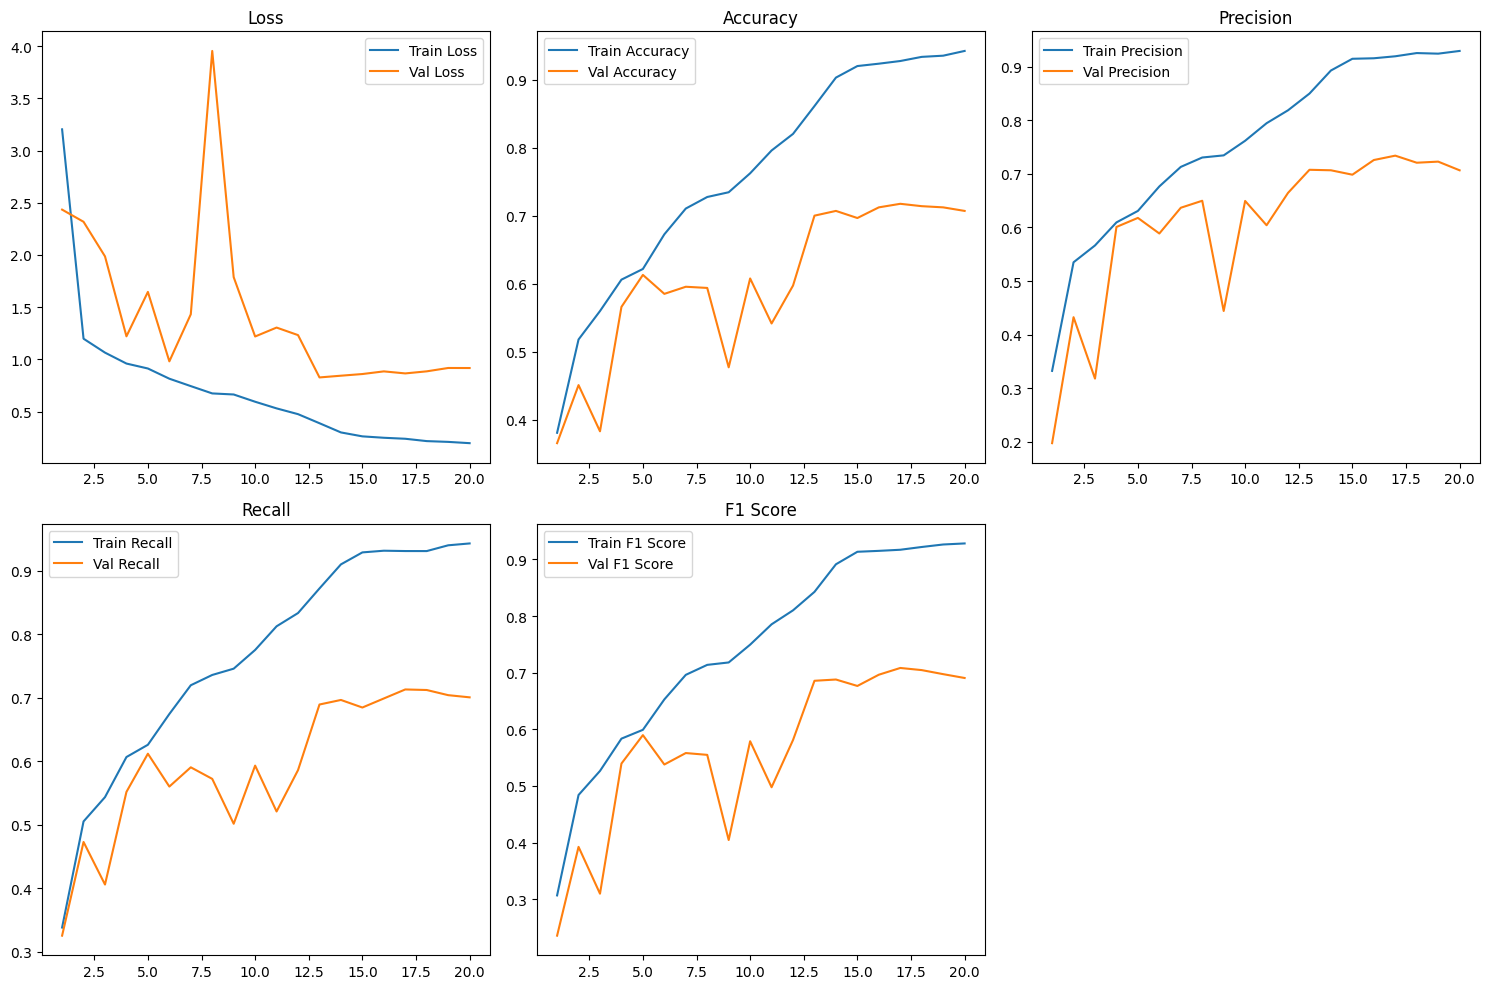

In [325]:
train_model(masked_train_loader, masked_val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet34

Epoch 1/35
Validation loss decreased (inf --> 1.285572). Saving the model!
[Epoch 1/35] Train Loss: 1.457, Train Acc: 0.44, Train Precision: 0.42, Train Recall: 0.42, Train F1: 0.36, Val Loss: 1.286, Val Acc: 0.46, Val Precision: 0.39, Val Recall: 0.42, Val F1: 0.33
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.098, Train Acc: 0.53, Train Precision: 0.54, Train Recall: 0.51, Train F1: 0.48, Val Loss: 1.311, Val Acc: 0.51, Val Precision: 0.60, Val Recall: 0.49, Val F1: 0.43
Epoch 3/35
Validation loss did not improve this epoch. (2/7)
[Epoch 3/35] Train Loss: 1.034, Train Acc: 0.58, Train Precision: 0.61, Train Recall: 0.57, Train F1: 0.54, Val Loss: 1.291, Val Acc: 0.44, Val Precision: 0.50, Val Recall: 0.47, Val F1: 0.40
Epoch 4/35
Validation loss did not improve this epoch. (3/7)
[Epoch 4/35] Train Loss: 0.919, Train Acc: 0.64, Train Precision: 0.66, Train Recall: 0.63, Train F1: 0.61, Val Loss: 1.326, Val Acc: 0.48, Val Precision: 0.57, Val R

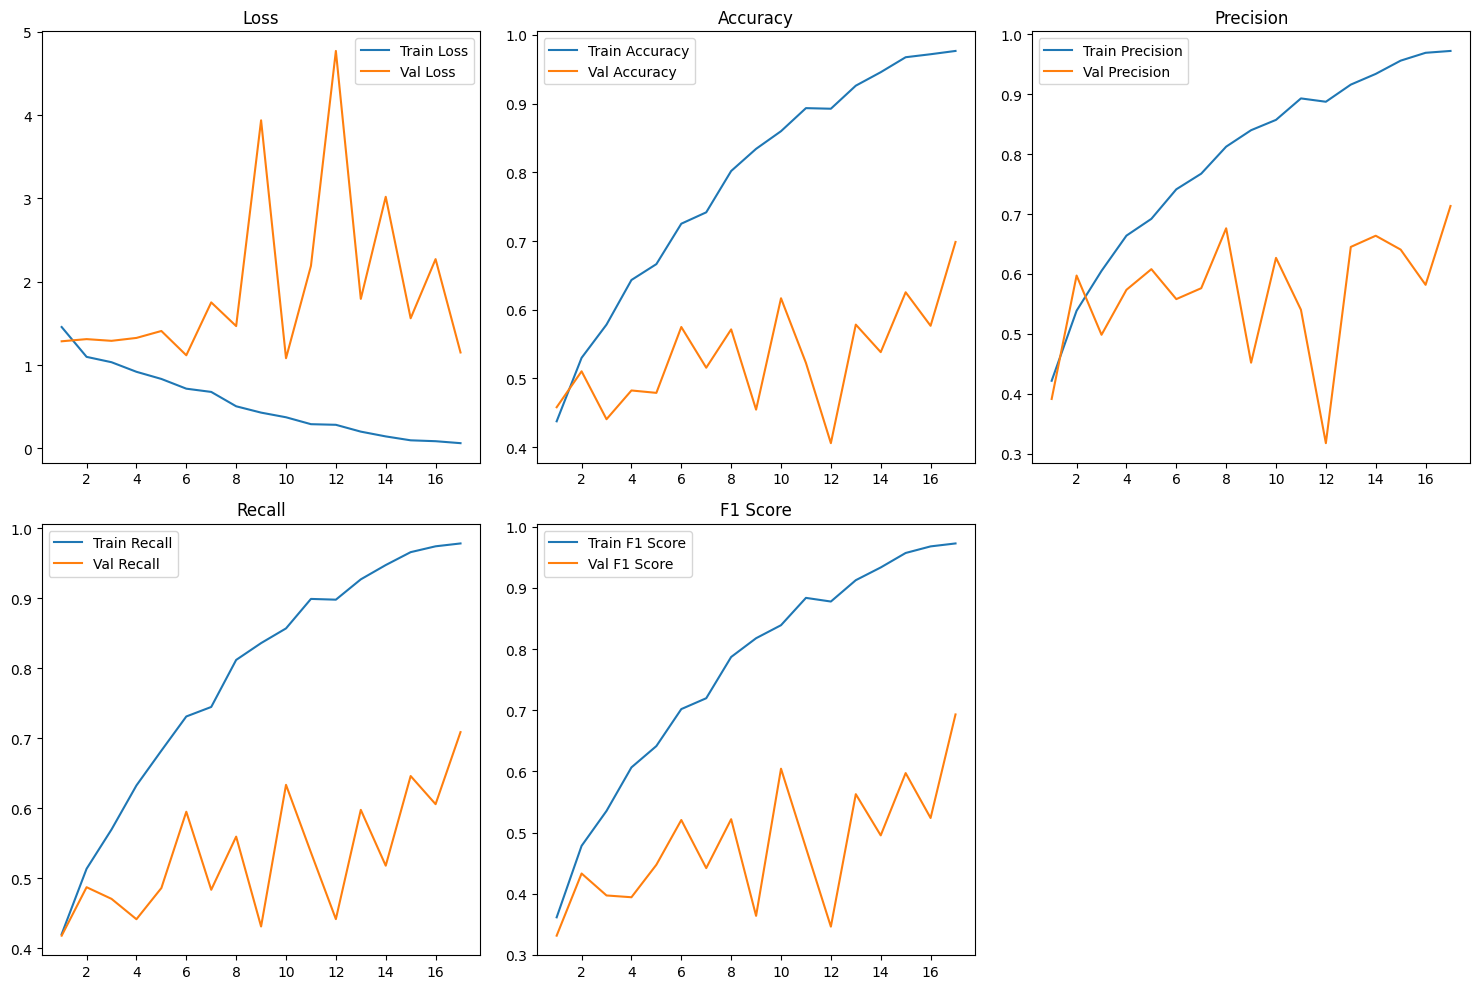

In [331]:
train_model(masked_train_loader, masked_val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet18

Epoch 1/35
Validation loss decreased (inf --> 1.107100). Saving the model!
[Epoch 1/35] Train Loss: 1.725, Train Acc: 0.43, Train Precision: 0.42, Train Recall: 0.42, Train F1: 0.37, Val Loss: 1.107, Val Acc: 0.54, Val Precision: 0.60, Val Recall: 0.53, Val F1: 0.51
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.044, Train Acc: 0.56, Train Precision: 0.57, Train Recall: 0.55, Train F1: 0.51, Val Loss: 1.135, Val Acc: 0.51, Val Precision: 0.59, Val Recall: 0.49, Val F1: 0.47
Epoch 3/35
Validation loss did not improve this epoch. (2/7)
[Epoch 3/35] Train Loss: 0.952, Train Acc: 0.61, Train Precision: 0.62, Train Recall: 0.60, Train F1: 0.57, Val Loss: 2.028, Val Acc: 0.43, Val Precision: 0.41, Val Recall: 0.43, Val F1: 0.35
Epoch 4/35
Validation loss did not improve this epoch. (3/7)
[Epoch 4/35] Train Loss: 0.854, Train Acc: 0.66, Train Precision: 0.69, Train Recall: 0.67, Train F1: 0.64, Val Loss: 1.183, Val Acc: 0.53, Val Precision: 0.53, Val R

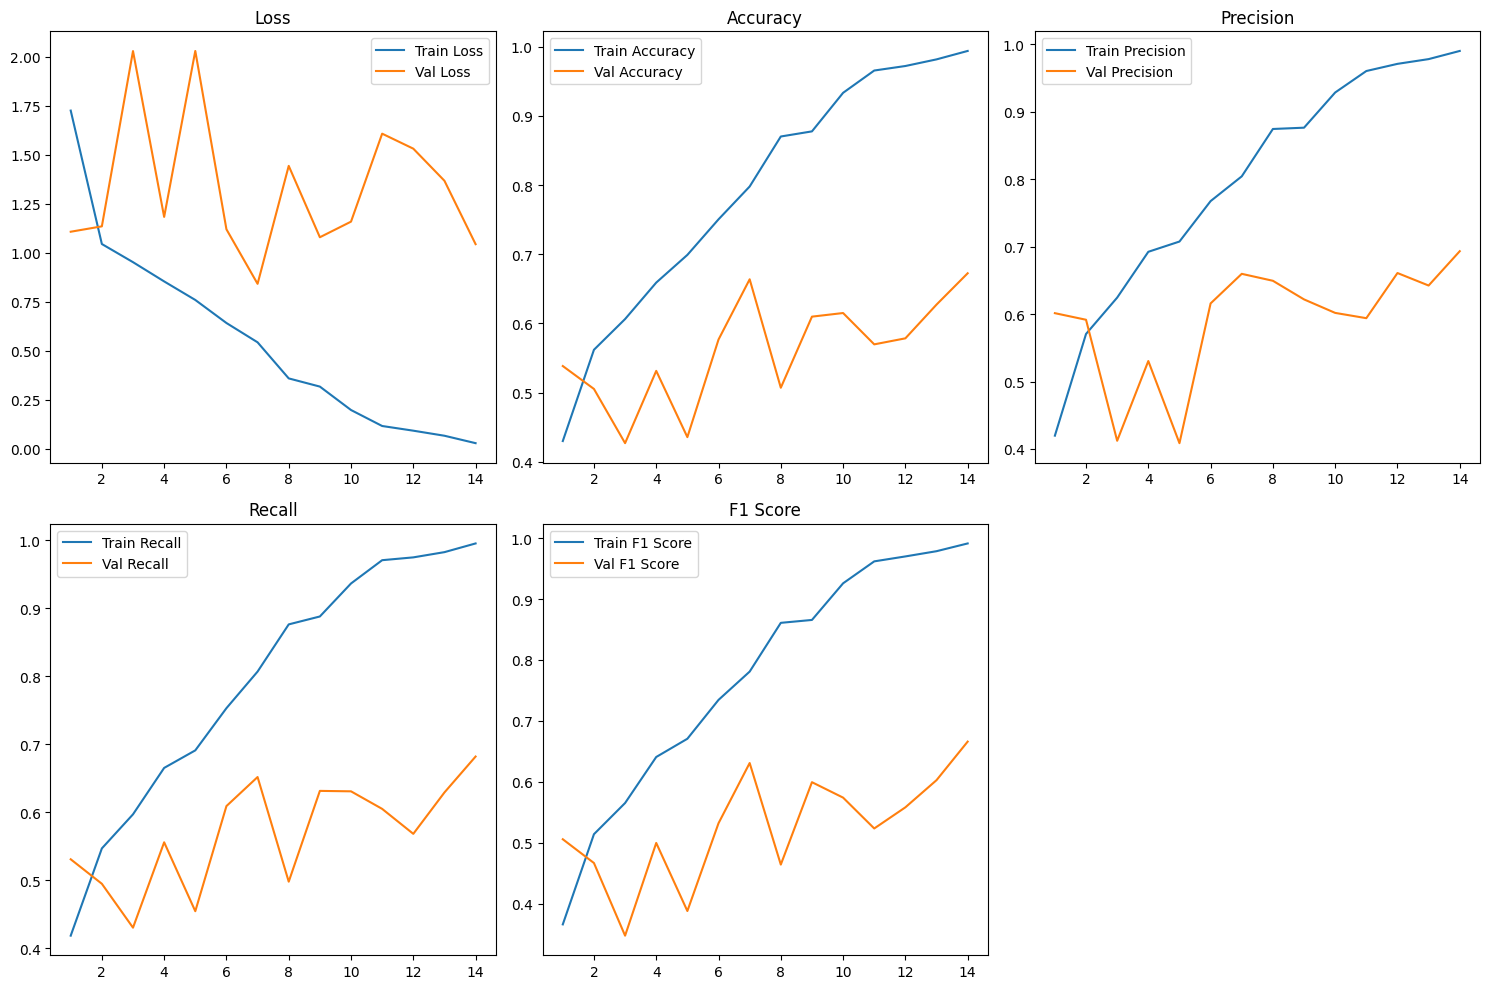

In [333]:
train_model(masked_train_loader, masked_val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

resnet50

Epoch 1/35
Validation loss decreased (inf --> 1.357131). Saving the model!
[Epoch 1/35] Train Loss: 1.952, Train Acc: 0.38, Train Precision: 0.27, Train Recall: 0.35, Train F1: 0.26, Val Loss: 1.357, Val Acc: 0.43, Val Precision: 0.40, Val Recall: 0.44, Val F1: 0.37
Epoch 2/35
Validation loss did not improve this epoch. (1/7)
[Epoch 2/35] Train Loss: 1.461, Train Acc: 0.43, Train Precision: 0.42, Train Recall: 0.43, Train F1: 0.37, Val Loss: 1.425, Val Acc: 0.51, Val Precision: 0.44, Val Recall: 0.45, Val F1: 0.41
Epoch 3/35
Validation loss did not improve this epoch. (2/7)
[Epoch 3/35] Train Loss: 1.228, Train Acc: 0.54, Train Precision: 0.53, Train Recall: 0.53, Train F1: 0.49, Val Loss: 2.825, Val Acc: 0.44, Val Precision: 0.30, Val Recall: 0.39, Val F1: 0.30
Epoch 4/35
Validation loss decreased (1.357131 --> 1.087746). Saving the model!
[Epoch 4/35] Train Loss: 1.153, Train Acc: 0.55, Train Precision: 0.58, Train Recall: 0.53, Train F1: 0.50, Val Loss: 1.088, Val Acc: 0.60, Val Pre

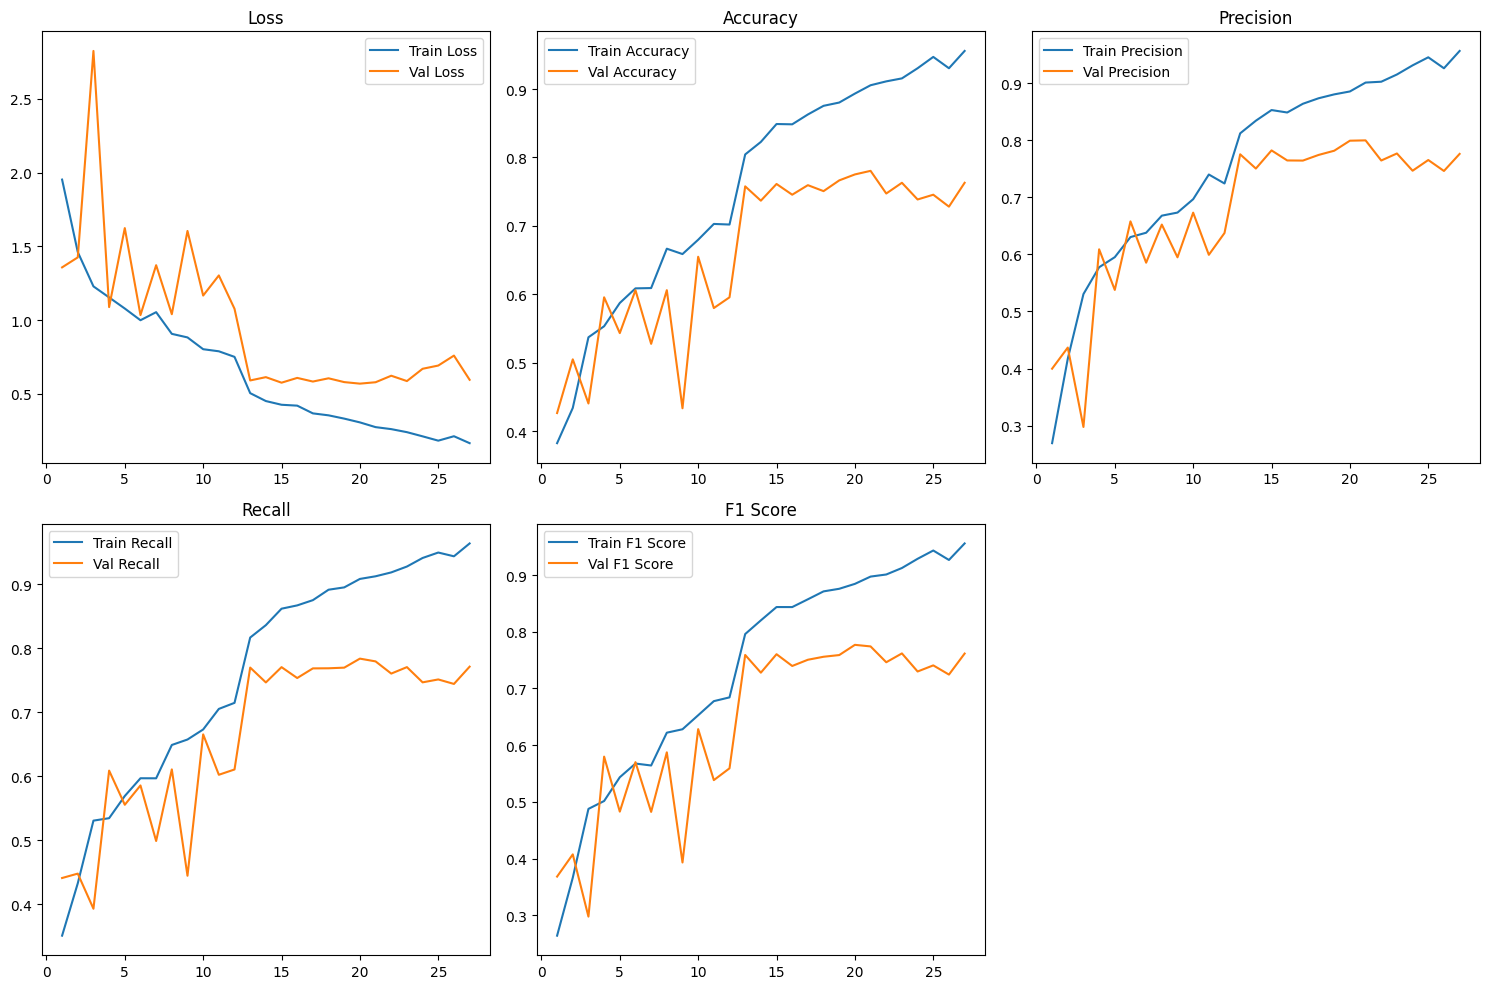

In [335]:
train_model(masked_train_loader, masked_val_loader, clf, criterion, opt, scheduler, device, n_epochs=35)

#### Check on test_set

In [42]:
def make_prediction(clf, test_loader, device):
    clf.eval()
    predictions = []
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            model_input,target = data[0].to(device), data[1].to(device)
            model_output = clf(model_input)
            _, preds = torch.max(model_output, 1)

            test_acc += preds.eq(target.view_as(preds)).sum().item()
            predictions.extend(preds.cpu().numpy())
    return test_acc / len(test_loader.dataset)

acc_pred = make_prediction(clf, test_loader, device)
acc_pred

0.6624365482233503